# Spaceship titanic  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
train=pd.read_csv("data/spaceship-titanic/train.csv")
test=pd.read_csv("data/spaceship-titanic/test.csv")

In [3]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
ID=test['PassengerId']

**각각의 특성에 대해서 알아보자.**
1. Passengerld: 승객의 ID
2. HomePlanet: 출신 행성
3. CryoSleep: 냉동 수면
4. Cabin: 객실
5. destination: 목적지
6. Transported: 차원이동여부
7. VRDeck: Deck은 갑판을 의미하는데 VRDeck이 정확히 무엇을 의미하는지는 모르겠다. 

### 데이터 알아보기

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [7]:
train["HomePlanet"].value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

전체 8693명 중 출신 행성이 지구인 사람은 4602명, 유로파위성인 사람은 2131명, 화성인 사람은 1759명이고 출신 행성 데이터가 없는 사람은 201명임을 알 수 있다.  
<br/>
우주선에서 소비한 금액을 하나로 합친다.

In [8]:
train["Expense"]=train["RoomService"]+train["FoodCourt"]+train["ShoppingMall"]+train["Spa"]+train["VRDeck"]
test["Expense"]=test["RoomService"]+test["FoodCourt"]+test["ShoppingMall"]+test["Spa"]+test["VRDeck"]

### 데이터 선별하기  

**'HomePlanet','Destination','CryoSleep','VIP,'Transported','Expense'**  
*유의미한 데이터로 추정*

처음 데이터를 위와 같이 선별했는데 Age도 Transported 유의미한 상관관계가 있을까하여 한번 분석해보려고한다.

범주형데이터끼리의 상관관계를 나타내기위해 age를 구간별로 나누었다.

In [9]:
train['Age']=pd.cut(train['Age'],bins=[0, 15, 25, 35, 60, 100],labels=['어린이', '청년', '장년', '중년', '노년'])

In [10]:
from scipy.stats import chi2_contingency

pd.crosstab(train['Age'],train['Transported'])

Transported,False,True
Age,,
어린이,402,660
청년,1410,1246
장년,1088,1017
중년,1176,1117
노년,116,104


딱히 유의미해 보이지 않아서 'Age'column은 제외

In [11]:
pd.crosstab(train['CryoSleep'],train['VIP'])

VIP,False,True
CryoSleep,,
False,5143,175
True,2941,21


'VIP' Column에 존재하는 결측치를 전부 0으로 메꿀 예정

### Expense분포 체크

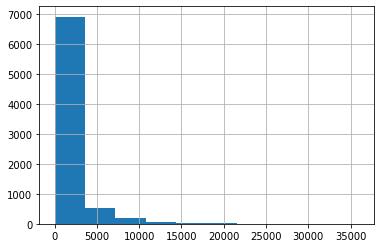

In [12]:
train["Expense"].hist()

In [13]:
train["Expense_cat"] = pd.cut(train["Expense"],
                               bins=[0., 2000, 4000, 6000, 8000, np.inf],
                               labels=[1, 2, 3, 4, 5])


In [14]:
train["Expense_cat"].value_counts()

1    3004
2     765
3     308
5     263
4     198
Name: Expense_cat, dtype: int64

In [15]:
pd.crosstab(train['Expense_cat'],train['Transported'])

Transported,False,True
Expense_cat,,
1,2143,861
2,517,248
3,193,115
4,138,60
5,180,83


우주선에서 얼마만큼 소비했는지는 차원이동 여부는 상관x

### 범주형 특성 다루기

In [16]:
train_home=pd.get_dummies(train['HomePlanet'],dummy_na=True)
test_home=pd.get_dummies(test['HomePlanet'],dummy_na=True)

train_des=pd.get_dummies(train['Destination'],dummy_na=True)
test_des=pd.get_dummies(test['Destination'],dummy_na=True)

train_home

,Earth,Europa,Mars,NaN
0,0,1,0,0
1,1,0,0,0
2,0,1,0,0
3,0,1,0,0
4,1,0,0,0
...,...,...,...,...
8688,0,1,0,0
8689,1,0,0,0
8690,1,0,0,0
8691,0,1,0,0


In [17]:
train=pd.concat((train_home,train_des,train[['CryoSleep','VIP','Expense','Transported']]),axis=1)
test=pd.concat((test_home,test_des,test[['CryoSleep','VIP','Expense']]),axis=1)

In [18]:
train.head()

,Earth,Europa,Mars,NaN,55 Cancri e,PSO J318.5-22,TRAPPIST-1e,NaN,CryoSleep,VIP,Expense,Transported
0,0,1,0,0,0,0,1,0,False,False,0.0,False
1,1,0,0,0,0,0,1,0,False,False,736.0,True
2,0,1,0,0,0,0,1,0,False,True,10383.0,False
3,0,1,0,0,0,0,1,0,False,False,5176.0,False
4,1,0,0,0,0,0,1,0,False,False,1091.0,True


In [19]:
train=train.replace([False,True],[0,1])
test=test.replace([False,True],[0,1])

train.head()

,Earth,Europa,Mars,NaN,55 Cancri e,PSO J318.5-22,TRAPPIST-1e,NaN,CryoSleep,VIP,Expense,Transported
0,0,1,0,0,0,0,1,0,0.0,0.0,0.0,0
1,1,0,0,0,0,0,1,0,0.0,0.0,736.0,1
2,0,1,0,0,0,0,1,0,0.0,1.0,10383.0,0
3,0,1,0,0,0,0,1,0,0.0,0.0,5176.0,0
4,1,0,0,0,0,0,1,0,0.0,0.0,1091.0,1


### 상관계수조사

In [20]:
corr_matrix = train.corr()
corr_matrix["Transported"].sort_values(ascending=False)

Transported      1.000000
CryoSleep        0.468645
Europa           0.176916
55 Cancri e      0.108722
Mars             0.019544
NaN              0.002712
NaN              0.000547
PSO J318.5-22    0.000092
VIP             -0.037650
TRAPPIST-1e     -0.094700
Earth           -0.169019
Expense         -0.197671
Name: Transported, dtype: float64

### 결측값 채우기

In [21]:
train.isnull().sum()

Earth              0
Europa             0
Mars               0
NaN                0
55 Cancri e        0
PSO J318.5-22      0
TRAPPIST-1e        0
NaN                0
CryoSleep        217
VIP              203
Expense          908
Transported        0
dtype: int64

In [22]:
train['Expense'][train['Expense'].isnull()]

7      NaN
10     NaN
16     NaN
23     NaN
25     NaN
        ..
8642   NaN
8643   NaN
8665   NaN
8667   NaN
8675   NaN
Name: Expense, Length: 908, dtype: float64

homeplanet이 Europa거나 Destination이 55 Cancri e라면 CryoSleep이라고 가정

In [23]:
for i in range(train.shape[0]):
    if train.loc[i,'CryoSleep']!=1 and train.loc[i,'CryoSleep']!=0:
        if train.loc[i,'Europa']==1 or train.loc[i,'55 Cancri e']==1:
            train.loc[i,'CryoSleep']=1
        else:
            train.loc[i,'CryoSleep']=0
            
for i in range(test.shape[0]):
    if test.loc[i,'CryoSleep']!=1 and test.loc[i,'CryoSleep']!=0:
        if test.loc[i,'Europa']==1 or test.loc[i,'55 Cancri e']==1:
            test.loc[i,'CryoSleep']=1
        else:
            test.loc[i,'CryoSleep']=0
    

train.loc[train['VIP'] != train['VIP'], 'VIP'] = 0
test.loc[test['VIP'] != test['VIP'], 'VIP'] = 0

train.loc[train['Expense'] != train['Expense'], 'Expense'] = train['Expense'].mean()
test.loc[test['Expense'] != test['Expense'], 'Expense'] = test['Expense'].mean()

In [24]:
train.isnull().sum()

Earth            0
Europa           0
Mars             0
NaN              0
55 Cancri e      0
PSO J318.5-22    0
TRAPPIST-1e      0
NaN              0
CryoSleep        0
VIP              0
Expense          0
Transported      0
dtype: int64

In [25]:
train.loc[7]

Earth               1.000000
Europa              0.000000
Mars                0.000000
NaN                 0.000000
55 Cancri e         0.000000
PSO J318.5-22       0.000000
TRAPPIST-1e         1.000000
NaN                 0.000000
CryoSleep           1.000000
VIP                 0.000000
Expense          1484.601541
Transported         1.000000
Name: 7, dtype: float64

In [26]:
x=train.drop("Transported",axis=1)
y=train['Transported']

In [27]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [29]:
params_clf = { 'n_estimators' : [50, 100, 200, 300, 400],
           'max_depth' : [4, 6, 8, 10, 12, 16],
           'min_samples_leaf' : [4, 8, 12, 16, 20],
           'min_samples_split' : [4, 8, 12, 16, 20]
         }

In [30]:
from sklearn.model_selection import RandomizedSearchCV
clf = RandomizedSearchCV(clf, param_distributions=params_clf, n_iter=30, scoring="roc_auc", n_jobs=-1)

In [31]:
clf.fit(x_train, y_train)

RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
            

In [32]:
model = RandomForestClassifier(n_estimators = 200, random_state=5, max_depth = 12, min_samples_leaf = 4, min_samples_split = 4, oob_score=True)
model.fit(x_train, y_train)

print("train_set_accuracy: {:.3f}".format(model.score(x_train, y_train)) )
print("test_set_accuracy: {:.3f}".format(model.score(x_test, y_test)) )
print("OOB_sample_accuracy: {:.3f}".format(model.oob_score_) )

train_set_accuracy: 0.749
test_set_accuracy: 0.719
OOB_sample_accuracy: 0.727


In [33]:
model2 = RandomForestClassifier(n_estimators = 200, random_state=5, max_depth = 16, min_samples_leaf = 8, min_samples_split = 8, oob_score=True)
model2.fit(x_train, y_train)

print("train_set_accuracy: {:.3f}".format(model2.score(x_train, y_train)) )
print("test_set_accuracy: {:.3f}".format(model2.score(x_test, y_test)) )
print("OOB_sample_accuracy: {:.3f}".format(model2.oob_score_) )

train_set_accuracy: 0.751
test_set_accuracy: 0.723
OOB_sample_accuracy: 0.731


In [34]:
model3 = RandomForestClassifier(n_estimators = 400, random_state=5, max_depth = 12, min_samples_leaf = 4, min_samples_split = 16, oob_score=True)
model3.fit(x_train, y_train)

print("train_set_accuracy: {:.3f}".format(model3.score(x_train, y_train)) )
print("test_set_accuracy: {:.3f}".format(model3.score(x_test, y_test)) )
print("OOB_sample_accuracy: {:.3f}".format(model3.oob_score_) )

train_set_accuracy: 0.747
test_set_accuracy: 0.721
OOB_sample_accuracy: 0.731


In [35]:
model4 = RandomForestClassifier(n_estimators = 400, random_state=5, max_depth = 12, min_samples_leaf = 4, min_samples_split = 12, oob_score=True)
model4.fit(x_train, y_train)

print("train_set_accuracy: {:.3f}".format(model4.score(x_train, y_train)) )
print("test_set_accuracy: {:.3f}".format(model4.score(x_test, y_test)) )
print("OOB_sample_accuracy: {:.3f}".format(model4.oob_score_) )

train_set_accuracy: 0.747
test_set_accuracy: 0.719
OOB_sample_accuracy: 0.732


In [36]:
y_pred=model2.predict(test)

Y_pred=[]
for i in y_pred:
    if i==1.0:
        Y_pred.append(True)
    else:
        Y_pred.append(False)
        
submission = pd.DataFrame({
        "PassengerId": ID,
        "Transported": Y_pred
    })

submission.to_csv('submission.csv', index=False)